In [22]:
import tensorflow as tf
print(tf.__version__)

2.12.0


In [23]:
from tensorflow.keras.layers import Input, LSTM, GRU, SimpleRNN, Dense, GlobalMaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [24]:
df = pd.read_csv('BBAS3.SA.csv')

In [25]:
df.dropna()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-02,32.090000,32.930000,32.090000,32.930000,23.474606,9178100
1,2018-01-03,33.099998,33.419998,32.820000,33.349998,23.774012,8180700
2,2018-01-04,33.520000,33.959999,33.450001,33.669998,24.002119,9625200
3,2018-01-05,33.700001,33.900002,33.290001,33.669998,24.002119,5267800
4,2018-01-08,33.639999,33.750000,33.340000,33.750000,24.059156,5130600
...,...,...,...,...,...,...,...
984,2021-12-23,29.299999,29.480000,29.160000,29.219999,25.943962,7337800
985,2021-12-27,29.250000,29.490000,29.200001,29.280001,25.997232,5746200
986,2021-12-28,29.340000,29.389999,29.010000,29.110001,25.846296,8640700
987,2021-12-29,29.180000,29.309999,28.940001,28.959999,25.713108,7666400


In [26]:
series = df[ 'Close' ].values.reshape(-1,1)

In [27]:
scaler = StandardScaler()
scaler.fit(series[:len(series) // 2])
series = scaler.transform(series).flatten()

In [28]:
T = 10
D = 1
X = []
Y = []
for t in range(len(series) - T ):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T, 1)
Y = np.array(Y)
N = len(x)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (979, 10, 1) Y.shape (979,)


In [75]:
i = Input(shape=(T,1))
x = LSTM(5)(i)
x = Dense(1)(x)
model = Model(i, x)
model.compile(
    loss = 'mse',
    optimizer = Adam(learning_rate=0.1,)
)

r = model.fit(
    X[:-30], Y[:-30],  # Usando todos os dados, exceto as últimas 30 amostras para treinamento
    epochs=300,
    validation_data=(X[-30:], Y[-30:]),  # Usando as últimas 30 amostras para validação
)

Epoch 1/300
30/30 [==============================] - 3s 18ms/step - loss: 0.1414 - val_loss: 0.0185
Epoch 2/300
30/30 [==============================] - 0s 6ms/step - loss: 0.0222 - val_loss: 0.0065
Epoch 3/300
30/30 [==============================] - 0s 7ms/step - loss: 0.0179 - val_loss: 0.0058
Epoch 4/300
30/30 [==============================] - 0s 7ms/step - loss: 0.0169 - val_loss: 0.0085
Epoch 5/300
30/30 [==============================] - 0s 7ms/step - loss: 0.0177 - val_loss: 0.0094
Epoch 6/300
30/30 [==============================] - 0s 7ms/step - loss: 0.0174 - val_loss: 0.0055
Epoch 7/300
30/30 [==============================] - 0s 6ms/step - loss: 0.0180 - val_loss: 0.0109
Epoch 8/300
30/30 [==============================] - 0s 6ms/step - loss: 0.0176 - val_loss: 0.0059
Epoch 9/300
30/30 [==============================] - 0s 7ms/step - loss: 0.0164 - val_loss: 0.0057
Epoch 10/300
30/30 [==============================] - 0s 6ms/step - loss: 0.0162 - val_loss: 0.0059
Epoch 11

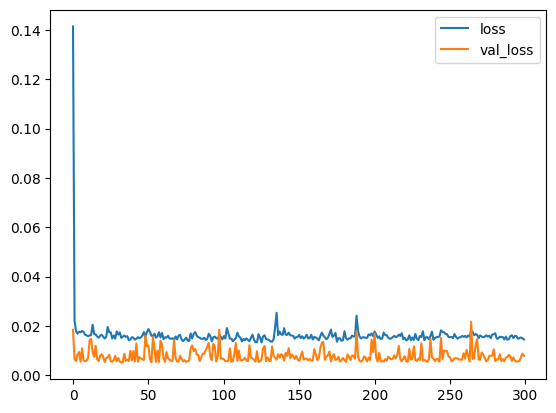

In [76]:
plt.plot(r.history['loss'], label = 'loss')
plt.plot(r.history['val_loss'], label = 'val_loss')
plt.legend()

31/31 [==============================] - 0s 2ms/step
(979, 1)


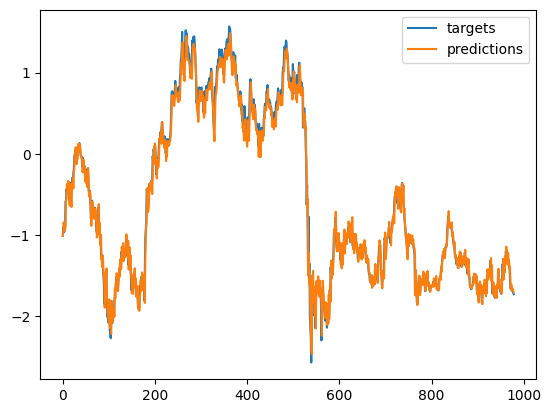

In [77]:
outputs = model.predict(X)
print(outputs.shape)
predictions = outputs[:, 0]

plt.plot(Y, label = 'targets')
plt.plot(predictions, label = 'predictions')
plt.legend()
plt.show()

In [78]:
# Previsões para o próximo dia e para o próximo mês.
last_sequence = X[-1]  # Última sequência dos dados.

next_day_prediction = model.predict(last_sequence.reshape(1, T, 1))[0, 0]
next_month_sequence = np.roll(last_sequence, -1)
next_month_sequence[-1] = next_day_prediction

1/1 [==============================] - 0s 17ms/step


In [79]:
next_month_predictions = []
for _ in range(30):
    next_month_prediction = model.predict(next_month_sequence.reshape(1, T, 1))[0, 0]
    next_month_predictions.append(next_month_prediction)
    next_month_sequence = np.roll(next_month_sequence, -1)
    next_month_sequence[-1] = next_month_prediction

1/1 [==============================] - 0s 22ms/step


In [80]:
# Desnormalizar os dados
next_day_prediction = scaler.inverse_transform(np.array(next_day_prediction).reshape(-1, 1)).flatten()
next_month_predictions = scaler.inverse_transform(np.array(next_month_predictions).reshape(-1, 1)).flatten()

In [84]:
print("Next Day Prediction:", next_day_prediction)
print("Next Month Predictions:", next_month_predictions)

Next Day Prediction: [29.026545]
Next Month Predictions: [29.161299 29.278952 29.380722 29.472446 29.557    29.635748 29.710512
 29.782776 29.85358  29.923628 29.993166 30.062262 30.130997 30.19949
 30.267876 30.336315 30.404972 30.474024 30.54364  30.613995 30.685268
 30.757637 30.83129  30.906414 30.98322  31.061916 31.142738 31.225922
 31.311731 31.400448]


In [81]:
 # Preparando as datas para o eixo x.
dates = pd.to_datetime(df['Date'])
next_day_date = dates.iloc[-1] + pd.DateOffset(days=1)
next_month_dates = pd.date_range(start=dates.iloc[-1] + pd.DateOffset(days=2), periods=30, freq='D')


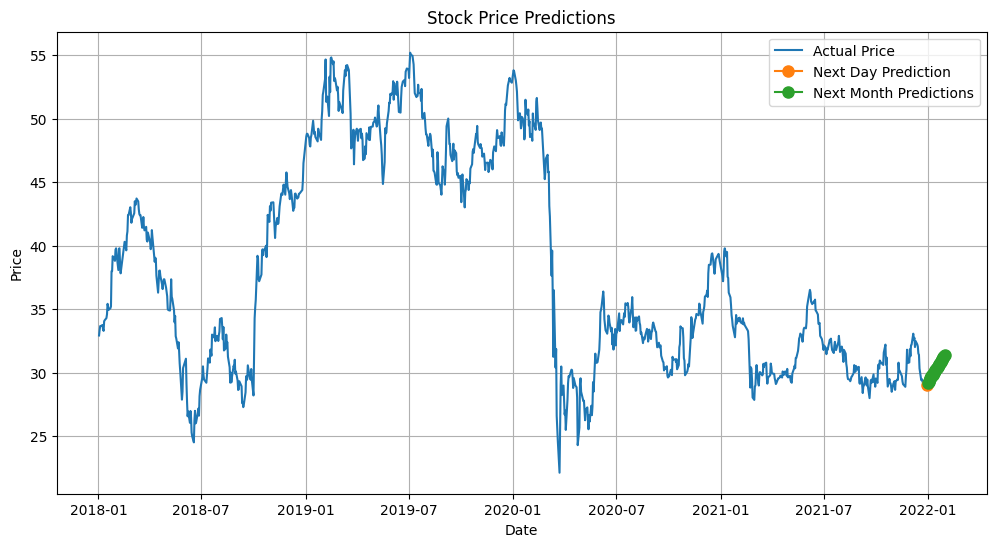

[29.161299 29.278952 29.380722 29.472446 29.557    29.635748 29.710512
 29.782776 29.85358  29.923628 29.993166 30.062262 30.130997 30.19949
 30.267876 30.336315 30.404972 30.474024 30.54364  30.613995 30.685268
 30.757637 30.83129  30.906414 30.98322  31.061916 31.142738 31.225922
 31.311731 31.400448]


In [82]:
plt.figure(figsize=(12, 6))
plt.plot(dates, df['Close'], label='Actual Price')
plt.plot(next_day_date, next_day_prediction, marker='o', markersize=8, label='Next Day Prediction')
plt.plot(next_month_dates, next_month_predictions, marker='o', markersize=8, label='Next Month Predictions')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Stock Price Predictions')
plt.legend()
plt.grid(True)
plt.show()
print(next_month_predictions)